### Illustrate the effect of overmature decline on CBM output

In [1]:
import os
import pandas as pd
%matplotlib inline

In [2]:
import cbm3_python.simulation.projectsimulator
from cbm3_python.cbm3data import cbm3_results
from cbm3_python.cbm3data import sit_helper
standard_import_tool_plugin_path=sit_helper.load_standard_import_tool_plugin()

### Source data

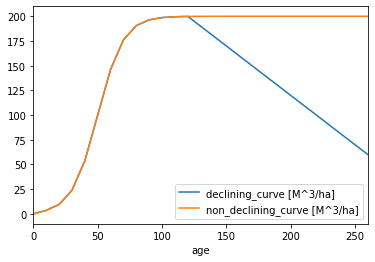

In [3]:
declining_curve = [
    0.0, 3.597241992, 9.485174636, 23.8405844, 53.78828427, 100, 146.2117157, 176.1594156,
    190.5148254, 196.402758, 198.6614298, 199.5054754, 199.8177898, 189.8177898, 179.8177898,
    169.8177898, 159.8177898, 149.8177898, 139.8177898, 129.8177898, 119.8177898, 109.8177898,
    99.81778976, 89.81778976, 79.81778976, 69.81778976, 59.81778976
  ]
non_declining_curve = [
    0.0, 3.597241992, 9.485174636, 23.8405844, 53.78828427, 100, 146.2117157, 176.1594156,
    190.5148254, 196.402758, 198.6614298, 199.5054754, 199.8177898, 199.93293, 199.9753211,
    199.9909204, 199.9966597, 199.9987712, 199.9995479, 199.9998337, 199.9999388, 199.9999775,
    199.9999917, 199.999997, 199.9999989, 199.9999996, 200
  ]
x_axis = [x*10 for x in range(len(declining_curve))]
pd.DataFrame(
    {"age": x_axis,
     "declining_curve [M^3/ha]": declining_curve,
     "non_declining_curve [M^3/ha]": non_declining_curve }) \
    .groupby("age").sum().plot()

### Import and simulation the project with CBM-CFS3

In [4]:
toolbox_path = r'C:\Program Files (x86)\Operational-Scale CBM-CFS3'
project_path = r"C:\Program Files (x86)\Operational-Scale CBM-CFS3\Projects\overmature_decline\overmature_decline.mdb"
results_db_path = r"C:\Program Files (x86)\Operational-Scale CBM-CFS3\Projects\overmature_decline\overmature_decline_results.mdb"
config_save_path =  r"C:\Program Files (x86)\Operational-Scale CBM-CFS3\Projects\overmature_decline\config.json"
c = sit_helper.SITConfig(
    imported_project_path=project_path,
    initialize_mapping=True
)
c.data_config(
    age_class_size=10,
    num_age_classes=27,
    classifiers=["Leading Species", "Scenario"])

c.set_single_spatial_unit(42)
c.set_species_classifier("Leading Species")

#create a 1 ha stand and growth curve for the purpose of simulating non-declining growth curve
c.add_inventory(
    classifier_set=["Spruce", "no_decline"],
    area=1, age=0, unfccc_land_class=0)
c.add_yield(
    classifier_set=["Spruce", "no_decline"],
    leading_species_classifier_value="Spruce",
    values=non_declining_curve)

#create a 1 ha stand for the purpose of simulating a declining growth curve
c.add_inventory(classifier_set=["Spruce", "with_decline"],
                area=1, age=0, unfccc_land_class=0)
c.add_yield(
    classifier_set=["Spruce", "with_decline"],
    leading_species_classifier_value="Spruce",
    values=declining_curve)


#dummy event to get the sit to run 150 years
c.add_event(classifier_set=["?","?"], disturbance_type="Wildfire", 
              time_step=250, target=30, target_type="Area", sort="SORT_BY_SW_AGE")

c.import_project(standard_import_tool_plugin_path, config_save_path)
results_db_path = cbm3_python.simulation.projectsimulator.run(
    aidb_path=os.path.join(toolbox_path, "admin", "dbs", "ArchiveIndex_Beta_Install.mdb"), 
    project_path=os.path.abspath(project_path), 
    toolbox_installation_dir=toolbox_path,
    cbm_exe_path=os.path.join(toolbox_path, "admin", "executables"),
    results_database_path= results_db_path)


In [5]:
pool_results = cbm3_results.load_pool_indicators(results_db_path,classifier_set_grouping=True)

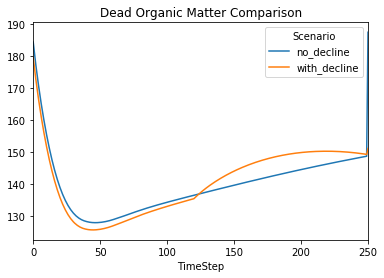

In [13]:
pool_results[["TimeStep","Scenario", "Dead Organic Matter"]] \
    .pivot(index="TimeStep", columns="Scenario", values="Dead Organic Matter") \
    .plot(title="Dead Organic Matter Comparison")


In [7]:
stock_change_results = cbm3_results.load_stock_changes(results_db_path, classifier_set_grouping=True)

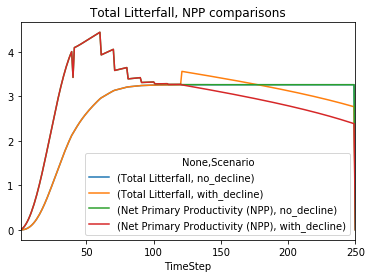

In [12]:
stock_change_results[["TimeStep","Scenario", 'Total Litterfall', 'Net Primary Productivity (NPP)']] \
    .pivot(index="TimeStep", columns="Scenario", values=['Total Litterfall', 'Net Primary Productivity (NPP)']) \
    .plot(title="Total Litterfall, NPP comparisons")
